In [1]:
%matplotlib inline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np
import dill

sns.set()

In [2]:
def load_dill(fname):
    with open(fname, 'rb') as f:
        return dill.load(f)
    
def dump_dill(fname, obj):
    with open(fname, 'wb') as f:
        dill.dump(obj, f)
    return None

def tune_knn_model(X_train, y_train):
    params = {'n_neighbors':[1,2,5,10,20], 'weights':['uniform','distance'], 'p':[1,2,3]}
    clf = KNeighborsClassifier()
    gs = GridSearchCV(clf, params, scoring='accuracy', cv=3, refit=True)
    gs.fit(X_train, y_train)
    return gs.best_estimator_

In [3]:
fname = 'banana_ncar_0.20.dill'
data = load_dill(fname)
X = data['X']
y = data['y']
y_new = data['y_new']

Visualize noise.

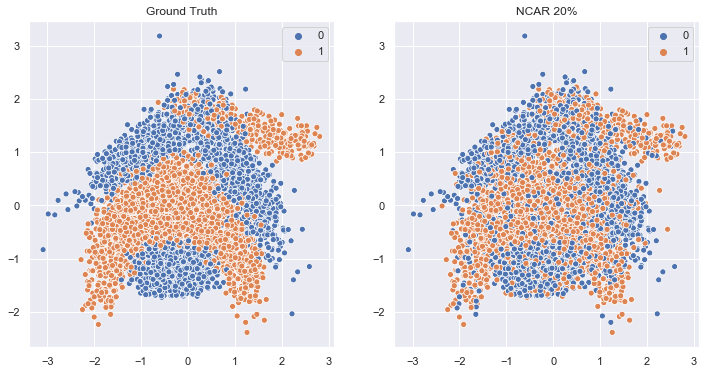

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.scatterplot(X[:,0], X[:,1], hue=y, ax=axes[0])
sns.scatterplot(X[:,0], X[:,1], hue=y_new[0], ax=axes[1])
axes[0].set_title('Ground Truth')
axes[1].set_title('NCAR 20%')
plt.show()

Get baseline performance.

In [5]:
num = 200
acc_true_true = []
for i in tqdm(range(num)):
    idx = np.arange(y.shape[0])
    idx_train, idx_test = train_test_split(idx, test_size=0.3, random_state=i)
    clf = tune_knn_model(X[idx_train], y[idx_train])
    y_pred = clf.predict(X[idx_test])
    acc_true_true.append(np.mean(y_pred == y[idx_test]))
acc_true_true = np.array(acc_true_true)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:12<00:00,  1.26s/it]


Get noise-trained performance.

In [6]:
num = 200
acc_noise_noise = []
acc_noise_true = []
for i, y_noise in enumerate(tqdm(y_new[:num])):
    idx = np.arange(y.shape[0])
    idx_train, idx_test = train_test_split(idx, test_size=0.3, random_state=i)
    clf = tune_knn_model(X[idx_train], y_noise[idx_train])
    y_pred = clf.predict(X[idx_test])
    acc_noise_noise.append(np.mean(y_pred == y_noise[idx_test]))
    acc_noise_true.append(np.mean(y_pred == y[idx_test]))
acc_noise_noise = np.array(acc_noise_noise)
acc_noise_true = np.array(acc_noise_true)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:05<00:00,  1.23s/it]


Compare performance.

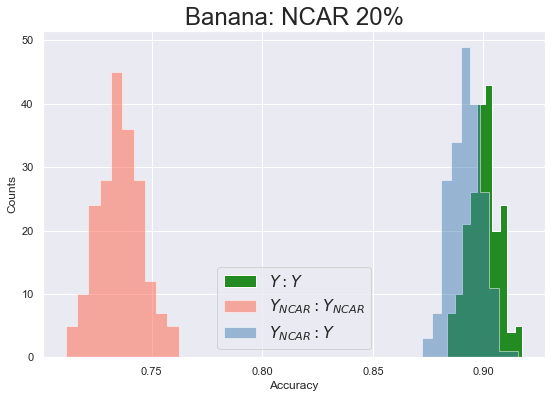

In [8]:
plt.figure(figsize=(9,6))
plt.hist(acc_true_true, color='forestgreen', histtype='stepfilled', label='$Y:Y$')
plt.hist(acc_noise_noise, color='tomato', alpha=0.5, histtype='stepfilled', label='$Y_{NCAR}:Y_{NCAR}$')
plt.hist(acc_noise_true, color='steelblue', alpha=0.5, histtype='stepfilled', label='$Y_{NCAR}:Y$')
plt.title('Banana: NCAR 20%', fontsize=24)
plt.legend(loc='best', fontsize=16)
plt.xlabel('Accuracy')
plt.ylabel('Counts')
plt.show()